This document goes through an illustrative thermokinetic modelling problem.
Instead of using our software Maud, everything is done from scratch using
Julia. Unlike Maud, which does Bayesian inference, this example just solves the
steady state problem for a given parameter assignment.

# The example problem

The reaction network looks like this:

![](./img/simple-network.png)

The box surrounded by a dotted line indicates which species should have
constant concentration in order to consider the system in a steady state.
Species M1 and M4 are considered 'unbalanced': in other words, the system is
considered steady even if they are being created or consumed.

This graph can be summed up by the following stoichiometric matrix $S$:

$$
\begin{bmatrix}
  -1. &  0. &  0.\\
   1. & -1. &  0.\\
   0. &  1. & -1.\\
   0. &  0. &  1.
\end{bmatrix}
$$ {#eq-steady}

Note that $S$ is less than full-rank, so we have the conservation relationship
problem.

The aim here is to write some Julia functions for representing metabolic
fluxes, use these functions to formulate the example network and then solve the
steady state problem, i.e. find an assignment of concentrations to M1 and M2
that does not change.

# Julia functions for representing metabolic fluxes

To formulate the problem I wrote some Julia functions that can be found in the
file `thermokinetics.jl`. These pretty faithfully copy their equivalents in
Maud, which can be found
[here](https://github.com/biosustain/Maud/blob/master/src/maud/stan/functions.stan).
The main differences are that the Julia functions are much easier to read,
mainly since the language supports ragged arrays, and that I didn't bother to
implement regulation by phosphorylation.

As a lightweight way of defining what a problem should look like for the
purposes of this exercise, I also made two Julia `structs`: `OdeUnknowns` for
unknown parameters, and `OdeInfo` for all the information required to solve a
steady state problem (except the starting balanced species concentration).

```{.julia include="./thermokinetics.jl" start-line=18 end-line=40}
```
# Formulating the example problem

The first step is to import the custom thermokinetics functions and import the
`DifferentialEquations` and `Plots` libraries, which will be used later.


In [1]:
include("./thermokinetics.jl")
using .Thermokinetics
using DifferentialEquations
using Plots

Next I chose the following parameter configuration pretty arbitrarily and put
them in an `OdeUnknowns` struct:


In [2]:
example_unknowns = OdeUnknowns(
  enzyme=[0.5, 0.5, 0.5],
  conc_unbalanced=[2., 1.],
  kcat=[12., 1., 5.],
  dgf=[25., 25., 50., 50.],
  km=[1., 1., 1., 1., 1., 1.],
  tc=[0., 0., 1.2],                # NB all reactions must have a tc 
  ki=[1.5],
  dc=[12.5]
)

OdeUnknowns([0.5, 0.5, 0.5], [2.0, 1.0], [12.0, 1.0, 5.0], [25.0, 25.0, 50.0, 50.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.5], [12.5], [0.0, 0.0, 1.2])

The next code cell represents the example problem using the `OdeInfo` struct:


In [3]:
example_S = Matrix(
  [-1.  0.  0.;
    1. -1.  0.;
    0.  1. -1.;
    0.  0.  1.;]
)
example_ode_info = OdeInfo(
  S=example_S,
  ix_balanced=[2, 3],
  subunits=[1, 2, 1],
  sp_to_km=[Dict(1=>1, 2=>2), Dict(2=>3, 3=>4), Dict(3=>5, 4=>6)],
  sp_to_ki=[Dict([]), Dict(2=>1), Dict([])],
  sp_to_dc=[Dict([]), Dict([]), Dict(3=>1)],
  allosteric_inhibitors=[[], [], [3]],
  allosteric_activators=[[], [], []],
  unknowns=example_unknowns
)

OdeInfo([-1.0 0.0 0.0; 1.0 -1.0 0.0; 0.0 1.0 -1.0; 0.0 0.0 1.0], Integer[2, 3], Integer[1, 2, 1], Dict{Integer, Integer}[Dict(2 => 2, 1 => 1), Dict(2 => 3, 3 => 4), Dict(4 => 6, 3 => 5)], Dict{Integer, Integer}[Dict(), Dict(2 => 1), Dict()], Dict{Integer, Integer}[Dict(), Dict(), Dict(3 => 1)], Vector{Integer}[[], [], [3]], Vector{Integer}[[], [], []], OdeUnknowns([0.5, 0.5, 0.5], [2.0, 1.0], [12.0, 1.0, 5.0], [25.0, 25.0, 50.0, 50.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.5], [12.5], [0.0, 0.0, 1.2]))

To check that everything was working I tried calling the `Sv` function from
`thermokinetics.jl` to see what the rate of change of the balanced species
would be if their concentrations were 1.0 and 2.0 respectively.


In [4]:
Sv([1., 2.], example_ode_info, 0.1) # the 0.1 doesn't do anything

2-element Vector{Float64}:
 12.039660056657224
 -6.95840675480975

This seemed ok, so I tried choosing a starting concentration and timespan, then
making an `ODEProblem`:


In [5]:
tspan = (0., 20.)
example_starting_concentration = [0.4, 1.2]

prob = ODEProblem(Sv, example_starting_concentration, tspan, example_ode_info)
prob

ODEProblem with uType Vector{Float64} and tType Float64. In-place: false
timespan: (0.0, 20.0)
u0: 2-element Vector{Float64}:
 0.4
 1.2

Finally, I tried solving the problem and putting the results in a matrix:


In [6]:
sol = solve(prob, TRBDF2(autodiff=false))
u = transpose(reduce(hcat, sol.u))
u

17×2 transpose(::Matrix{Float64}) with eltype Float64:
 0.4       1.2
 0.401639  1.19902
 0.418345  1.18929
 0.618813  1.09847
 0.994538  0.989472
 1.40419   0.900338
 1.80665   0.803208
 2.01784   0.668918
 2.0025    0.647219
 1.99914   0.616281
 1.99979   0.616863
 1.99971   0.617088
 1.99972   0.617041
 1.99972   0.61705
 1.99972   0.617049
 1.99972   0.617049
 1.99972   0.617049

This graph plots the simulated concentration timecourses on log-10 scale:^[The
starting concentrations are excluded to avoid a zero on the x axis]


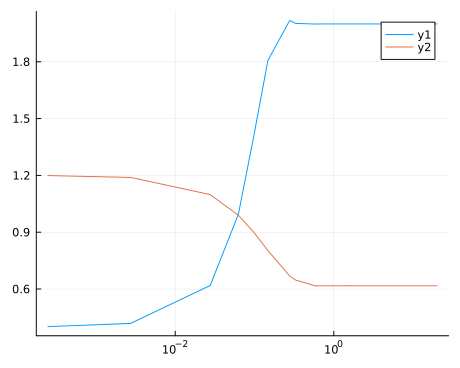

In [7]:
plot(sol.t[2:end], u[2:end, :], xscale=:log10)

# What next?

Now we need to see how to solve this problem as fast as possible, for a range
of different parameter values. We also need to find out the sensitivities of
the steady state solution to the parameters.